# **Dataset Preparation**

In [39]:
import numpy as np
import re
from torch.utils import data

In [40]:
# loading dataset
train_data = open('train.txt', 'r').read()
test_data = open('test.txt', 'r').read()
valid_data = open('valid.txt', 'r').read()

In [41]:
# clean data by removing unnecessary substrings
def clean_data(data):
  data = data.replace('< u n k >', '').replace('\n', '_').replace(' ', '')
  data = re.sub(r'[^a-z_]', '', data)
  data = re.sub('_{2,}', '_', data)
  return data

def save_data(data, name):
  f = open(name, "w")
  f.write(data)
  f.close()

train_data = clean_data(train_data)
test_data = clean_data(test_data)
valid_data = clean_data(valid_data)

save_data(train_data, "train_data_clean.txt")
save_data(test_data, "test_data_clean.txt")
save_data(valid_data, "valid_data_clean.txt")

In [42]:
vocab_chars = list(set(train_data))
vocab_size = len(vocab_chars)
print(f'Number of unique characters is {vocab_size}')

char2idx = { ch:i for i,ch in enumerate(vocab_chars) }
idx2char = { i:ch for i,ch in enumerate(vocab_chars) }

Number of unique characters is 27


In [43]:
class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        x = self.inputs[index]
        y = self.targets[index]
        return x, y

def get_inputs_targets(data, sequence_length):
  inputs, targets = [], []

  # inputs and targets contain L-1 chars of a sequence of length L
  # but targets are shifted right by one so that we can predict the next char
  sequence_length += 1
  for i in range(sequence_length, len(data), sequence_length):
      sequence = data[i-sequence_length:i]
      inputs.append(sequence[:-1])
      targets.append(sequence[1:])
      
  return inputs, targets

sequence_length = 100  # Hyperparameter
inputs_train, targets_train = get_inputs_targets(train_data, sequence_length)
inputs_val, targets_val = get_inputs_targets(test_data, sequence_length)
inputs_test, targets_test = get_inputs_targets(valid_data, sequence_length)

train_set = Dataset(inputs_train, targets_train)
test_set = Dataset(inputs_test, targets_test)
valid_set = Dataset(inputs_val, targets_val)

print(f'Number of input and target sequences for train: {len(train_set)}')
print(f'Number of input and target sequences for test: {len(test_set)}')
print(f'Number of input and target sequences for validation: {len(valid_set)}')

Number of input and target sequences for train: 228
Number of input and target sequences for test: 19
Number of input and target sequences for validation: 18


In [44]:
def one_hot_encode(idx, vocab_size):
    one_hot = np.zeros(vocab_size)
    one_hot[idx] = 1.0
    return one_hot

def one_hot_encode_sequence(sequence, vocab_size):
    encoding = np.array([one_hot_encode(char2idx[char], vocab_size) for char in sequence])
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    return encoding

any_char = one_hot_encode(char2idx['a'], vocab_size)
print(f'One-hot encoding of \'a\' has shape {any_char.shape}')

any_sequence = one_hot_encode_sequence(train_set.inputs[0], vocab_size)
print(f'One-hot encoding of \'{train_set.inputs[0]}\' has shape {any_sequence.shape}')

print(f'Before encoding train_set.inputs[0]: \'{train_set.inputs[0]}\'')

for data in [train_set, test_set, valid_set]:
  data.inputs = [one_hot_encode_sequence(input_sequence, vocab_size) for input_sequence in data.inputs]
  data.targets = [one_hot_encode_sequence(target_sequence, vocab_size) for target_sequence in data.targets]

decoded_sequence = ''.join([idx2char[np.argmax(char)] for char in train_set.inputs[0]])
print(f'After encoding train_set.inputs[0]: \'{decoded_sequence}\'')

One-hot encoding of 'a' has shape (27,)
One-hot encoding of 'the_dutch_publishing_group_rudolph_years_old_and_former_chairman_of_consolidated_gold_fields_plc_was' has shape (100, 27, 1)
Before encoding train_set.inputs[0]: 'the_dutch_publishing_group_rudolph_years_old_and_former_chairman_of_consolidated_gold_fields_plc_was'
After encoding train_set.inputs[0]: 'the_dutch_publishing_group_rudolph_years_old_and_former_chairman_of_consolidated_gold_fields_plc_was'


# **Functions**

In [45]:
def softmax(x):
    x = x + 1e-12
    return np.exp(x) / np.sum(np.exp(x))

In [46]:
def init_orthogonal(rows, cols):
    param = np.random.randn(rows, cols)
    
    if rows < cols: 
      param = param.T
    q, r = np.linalg.qr(param) # Compute QR factorization
    
    # Make Q uniform according to https://arxiv.org/pdf/math-ph/0609050.pdf
    d = np.diag(r)
    ph = np.sign(d)
    q *= ph

    if rows < cols: 
      q = q.T
    return q

In [47]:
def find_loss(outputs, targets):
    loss = 0.0
    for t in reversed(range(len(outputs))):
        loss += -np.log(outputs[t][np.argmax(targets[t])])
    return loss

In [48]:
def find_bpc(outputs, targets):
    bpc = 0.0
    for t in reversed(range(len(outputs))):
        bpc += -np.log2(outputs[t][np.argmax(targets[t])])
    bpc /= len(outputs)
    return bpc

In [49]:
def gradient_clip(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.linalg.norm(grad)
    total_norm = np.sqrt(total_norm)

    if total_norm > max_norm:
        for grad in grads:
            grad *= max_norm / total_norm
    return grads

In [50]:
def update_parameters(params, grads, lr):
    for param, grad in zip(params, grads):
        param -= lr * grad
    return params

# **Vanilla RNN**

In [51]:
class RNN():
    def __init__(self, hidden_size, vocab_size):
        V = init_orthogonal(hidden_size, hidden_size) # W_hh
        U = init_orthogonal(hidden_size, vocab_size)  # W_hx
        W = init_orthogonal(vocab_size, hidden_size)  # W_hy
        b_hidden = np.zeros((hidden_size, 1))         # b_h
        b_out = np.zeros((vocab_size, 1))             # b_y
        self.params = V, U, W, b_hidden, b_out
    
    def forward(self, inputs, hidden_state):
        V, U, W, b_hidden, b_out = self.params
        outputs, hidden_states = [], []
        for t in range(len(inputs)):
            hidden_state = np.tanh(np.dot(U, inputs[t]) + np.dot(V, hidden_state) + b_hidden)
            hidden_states.append(hidden_state.copy())
            out = softmax(np.dot(W, hidden_state) + b_out)
            outputs.append(out.copy())
        return outputs, hidden_states

    def backward(self, inputs, outputs, hidden_states, targets, gradient_clip_norm):
        V, U, W, b_hidden, b_out = self.params
        d_V, d_U, d_W = np.zeros_like(V), np.zeros_like(U), np.zeros_like(W)
        d_b_hidden, d_b_out = np.zeros_like(b_hidden), np.zeros_like(b_out)

        d_h_next = np.zeros_like(hidden_states[0])
        loss = 0.0
        
        # BPTT Loop
        for t in reversed(range(len(outputs))):
            loss += -np.log(outputs[t][np.argmax(targets[t])])

            d_o = outputs[t].copy()
            d_o[np.argmax(targets[t])] -= 1
            d_W += np.dot(d_o, hidden_states[t].T)
            d_b_out += d_o
            d_h = np.dot(W.T, d_o) + d_h_next
            d_f = (1 - hidden_states[t]**2) * d_h
            d_b_hidden += d_f
            d_U += np.dot(d_f, inputs[t].T)
            d_V += np.dot(d_f, hidden_states[t-1].T)
            d_h_next = np.dot(V.T, d_f)

        grads = d_V, d_U, d_W, d_b_hidden, d_b_out
        grads = gradient_clip(grads, gradient_clip_norm)
        return loss, grads

    def train(self, train_set, valid_set, hidden_state, num_epochs, learning_rate):
        training_loss, validation_loss = [], []
        for i in range(num_epochs + 1):
            epoch_training_loss = 0
            epoch_validation_loss = 0
            
            for inputs, targets in train_set:
                outputs, hidden_states = self.forward(inputs, hidden_state.copy())
                loss, grads = self.backward(inputs, outputs, hidden_states, targets, gradient_clip_norm)
                self.params = update_parameters(self.params, grads, learning_rate)
                epoch_training_loss += loss

            for inputs, targets in valid_set:
                outputs, _ = self.forward(inputs, hidden_state.copy())
                loss = find_loss(outputs, targets)
                epoch_validation_loss += loss
                    
            training_loss.append(epoch_training_loss/len(train_set))
            validation_loss.append(epoch_validation_loss/len(valid_set))

            if i % 10 == 0:
                print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')
        return training_loss, validation_loss

    def test(self, test_set, hidden_state):
        test_loss, test_bpc = 0, 0

        for inputs, targets in test_set:
            outputs, _ = self.forward(inputs, hidden_state)
            loss = find_loss(outputs, targets)
            bpc = find_bpc(outputs, targets)
            test_loss += loss
            test_bpc += bpc

        test_loss /= len(test_set)
        test_bpc /= len(test_set)
        print("Test loss: ", test_loss)
        print("Test BPC: ", test_bpc)
        return test_loss, test_bpc

Epoch 0, training loss: [319.58715957], validation loss: [307.81263166]
Epoch 10, training loss: [276.17020473], validation loss: [275.10801261]
Epoch 20, training loss: [264.14476335], validation loss: [263.05561878]
Epoch 30, training loss: [256.32188526], validation loss: [255.30672339]
Epoch 40, training loss: [250.02317902], validation loss: [248.90947301]
Epoch 50, training loss: [245.01988946], validation loss: [243.91817207]
Epoch 60, training loss: [241.42361988], validation loss: [240.53173514]
Epoch 70, training loss: [238.82085022], validation loss: [238.28304855]
Epoch 80, training loss: [236.80881984], validation loss: [236.69763687]
Epoch 90, training loss: [235.14940866], validation loss: [235.49798987]
Epoch 100, training loss: [233.72567971], validation loss: [234.54203184]
Test loss:  [242.04985545]
Test BPC:  [3.49204126]


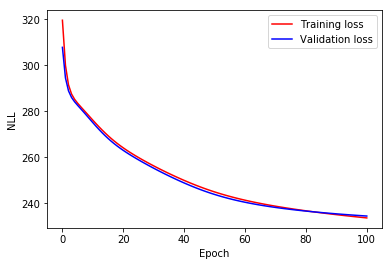

In [52]:
### Train Vanilla RNN ###

import matplotlib.pyplot as plt
%matplotlib inline

# Hyperparameters
hidden_size = 10
gradient_clip_norm = 0.1
learning_rate = 0.01
num_epochs = 100

rnn_model = RNN(hidden_size, vocab_size)
hidden_state = np.zeros((hidden_size, 1))  # Initial hidden_state
train_loss, valid_loss = rnn_model.train(train_set, valid_set, hidden_state, num_epochs, learning_rate)
test_loss, test_bpc = rnn_model.test(test_set, hidden_state)

# Plot training and validation loss
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss, 'r', label='Training loss',)
plt.plot(epoch, valid_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

# **HORNN**

In [53]:
class HORNN():
    def __init__(self, hidden_size, vocab_size, order):
        V = []
        for _ in range(order):
            V.append(init_orthogonal(hidden_size, hidden_size))
        U = init_orthogonal(hidden_size, vocab_size)
        W = init_orthogonal(vocab_size, hidden_size)
        b_hidden = np.zeros((hidden_size, 1))
        b_out = np.zeros((vocab_size, 1))

        self.params = tuple(V) + (U, W, b_hidden, b_out)
        self.order = order
    
    def forward(self, inputs, hidden_states_list):
        V = []
        for i in range(self.order):
            V.append(self.params[i])
        U, W, b_hidden, b_out = self.params[self.order:]

        outputs, hidden_states = [], []
        for t in range(len(inputs)):
            s = np.zeros_like(hidden_states_list[0])
            for i in range(self.order):
                s += np.dot(V[i], hidden_states_list[i])
            hidden_state = np.tanh(np.dot(U, inputs[t]) + s + b_hidden)
            
            # history window
            hidden_states_list.pop()                            # remove the oldest hidden_state
            hidden_states_list.insert(0, hidden_state.copy())   # place the new one at the beginning
            
            out = softmax(np.dot(W, hidden_state) + b_out)
            outputs.append(out.copy())
            hidden_states.append(hidden_state.copy())
        return outputs, hidden_states

    def backward(self, inputs, outputs, hidden_states, targets, gradient_clip_norm):
        V = []
        for i in range(self.order):
            V.append(self.params[i])
        U, W, b_hidden, b_out = self.params[self.order:]

        # Derivatives
        d_V = []
        for i in range(self.order):
            d_V.append(np.zeros_like(V[i]))
        d_U, d_W = np.zeros_like(U), np.zeros_like(W)
        d_b_hidden, d_b_out = np.zeros_like(b_hidden), np.zeros_like(b_out)
        
        # for updated equation
        arrayOfM = [0]*self.order
        arrayOfs = [0]*self.order
        
        d_h_next = np.zeros_like(hidden_states[0])
        loss = 0.0
        
        # BPTT Loop
        for t in reversed(range(len(outputs))):
            loss += -np.log(outputs[t][np.argmax(targets[t])])

            d_o = outputs[t].copy()
            d_o[np.argmax(targets[t])] -= 1
            d_W += np.dot(d_o, hidden_states[t].T)
            d_b_out += d_o
            
            # HORNN update
            #########################
            M = arrayOfM[0]
            for i in range(self.order-1):
                M = M * arrayOfs[i] + arrayOfM[i+1]
            
            s = arrayOfs[-1]
            l = np.dot(W.T, d_o)

            M = M * s + l
            arrayOfM = arrayOfM[1:]
            arrayOfM.append(M)

            d_f = (1 - hidden_states[t]**2)
            r = d_f * M
            for i in range(self.order):
                d_V[i] += np.dot(r, hidden_states[t-1-i].T)

            d_b_hidden += d_f * l
            d_U += np.dot(r, inputs[t].T)
            
            s = np.dot(V[0].T, d_f)
            arrayOfs = arrayOfs[1:]
            arrayOfs.append(s)
            #########################

        grads = tuple(d_V) + (d_U, d_W, d_b_hidden, d_b_out)  
        grads = gradient_clip(grads, gradient_clip_norm)
        return loss, grads
    
    def train(self, train_set, valid_set, hidden_states_list, num_epochs, learning_rate):
        training_loss, validation_loss = [], []
        for i in range(num_epochs+1):
            epoch_training_loss = 0
            epoch_validation_loss = 0

            for inputs, targets in train_set:
                outputs, hidden_states = self.forward(inputs, hidden_states_list.copy())
                loss, grads = self.backward(inputs, outputs, hidden_states, targets, gradient_clip_norm)
                self.params = update_parameters(self.params, grads, learning_rate)
                epoch_training_loss += loss

            for inputs, targets in valid_set:
                outputs, _ = self.forward(inputs, hidden_states_list.copy())
                loss = find_loss(outputs, targets)
                epoch_validation_loss += loss

            training_loss.append(epoch_training_loss/len(train_set))
            validation_loss.append(epoch_validation_loss/len(valid_set))

            if i % 10 == 0:
                print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')
        
        return training_loss, validation_loss

    def test(self, test_set, hidden_states_list):
        test_loss = 0
        test_bpc = 0

        for inputs, targets in test_set:
            outputs, _ = self.forward(inputs, hidden_states_list.copy())
            loss = find_loss(outputs, targets)
            bpc = find_bpc(outputs, targets)
            test_loss += loss
            test_bpc += bpc

        test_loss /= len(test_set)
        test_bpc /= len(test_set)
        print("Test loss: ", test_loss)
        print("Test BPC: ", test_bpc)

        return test_loss, test_bpc

Epoch 0, training loss: [337.02537661], validation loss: [332.2007313]
Epoch 10, training loss: [291.63720524], validation loss: [289.71855772]
Epoch 20, training loss: [285.82329418], validation loss: [285.84115545]
Epoch 30, training loss: [284.25874324], validation loss: [284.52154456]
Epoch 40, training loss: [281.73742321], validation loss: [281.38283989]
Epoch 50, training loss: [277.3007589], validation loss: [276.94886145]
Epoch 60, training loss: [272.06088674], validation loss: [271.64003141]
Epoch 70, training loss: [267.36247374], validation loss: [267.245365]
Epoch 80, training loss: [263.71110773], validation loss: [263.70546528]
Epoch 90, training loss: [264.07477269], validation loss: [262.81370042]
Epoch 100, training loss: [259.92482531], validation loss: [258.52085151]
Test loss:  [264.25907048]
Test BPC:  [3.8124525]


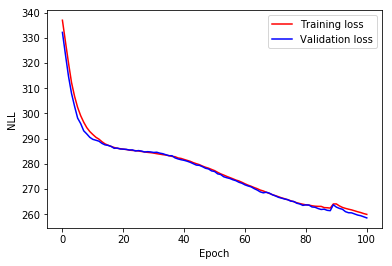

In [56]:
### Train Vanilla HORNN ###

import matplotlib.pyplot as plt
%matplotlib inline

# Hyperparameters
order = 5
hidden_size = 10
gradient_clip_norm = 0.1
learning_rate = 0.01
num_epochs = 100
# Model
hornn_model = HORNN(hidden_size, vocab_size, order)
hidden_states_list = [np.zeros((hidden_size, 1))] * order # Initial hidden_states
train_loss, valid_loss = hornn_model.train(train_set, valid_set, hidden_states_list, num_epochs, learning_rate)
test_loss, test_bpc = hornn_model.test(test_set, hidden_states_list)

# Plot training and validation loss
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss, 'r', label='Training loss',)
plt.plot(epoch, valid_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()